# Grid price impact

In [1]:
import numba
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numba import njit, prange

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
@njit
def sigmoid(z): return 1 / (1 + np.exp(-z))

@njit
def price_step(price, action, sigma, delta, price_impact):
    pr = sigmoid(action * price_impact)
    sign = np.random.uniform() > 1 - pr
    sign = 2 * sign - 1
    
    price_next = price + sigma * np.sqrt(delta) * sign
    price_next = np.maximum(0.0, price_next) # Minimum price is 0.0
    return price_next
    

@njit
def price_process(seed, num_steps, price_init, actions, sigma=1.0, delta=1.0, price_impact=1.0):
    """
    Price process when the actions are already known
    """
    np.random.seed(314)
    prices = np.zeros(num_steps)
    prices[0] = price_init
    for t in range(1, num_steps):
        prices[t] = price_step(prices[t-1], actions[t], sigma, delta, price_impact)
    return prices

### Example: buy at every step

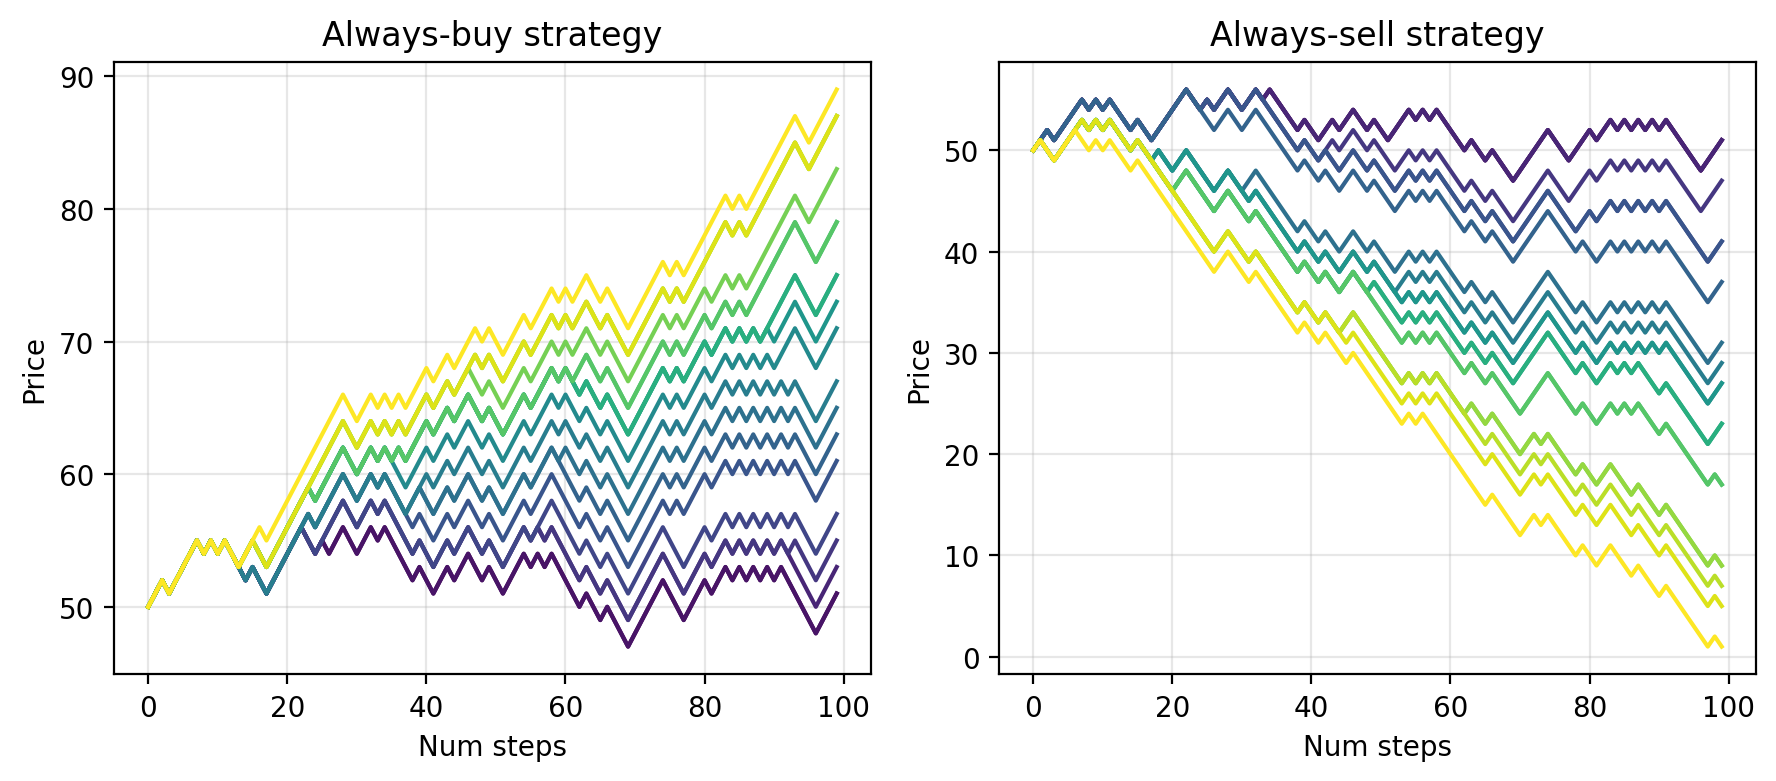

In [4]:
seed = 314
num_steps = 100
price_init = 50

price_impacts = np.linspace(0, 1, 20)
colors = plt.cm.viridis(price_impacts)

actions_buy = np.ones(num_steps)
actions_sell = -np.ones(num_steps)

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
for (price_impact, color) in zip(price_impacts, colors):
    
    prices_buy = price_process(seed, num_steps, price_init, actions_buy, price_impact=price_impact)
    ax[0].plot(prices_buy, c=color)
    
    prices_sell = price_process(seed, num_steps, price_init, actions_sell, price_impact=price_impact)
    ax[1].plot(prices_sell, c=color)


for axi in ax:
    axi.set_xlabel("Num steps")
    axi.set_ylabel("Price")
    axi.grid(alpha=0.3)

ax[0].set_title("Always-buy strategy")
ax[1].set_title("Always-sell strategy")


plt.tight_layout()

## Value iteration

Action-value function
$$
    q_\pi(s,\,a) = \sum_{s',\,r} p(s',\,r | s,\,a)[r + \gamma v(s')]
$$

In [5]:
@njit
def bern_pmf(y, mu):
    return mu ** y * (1 - mu) ** (1 - y)

@njit
def mdp(
    reward,
    price_next, inventory_next, cash_next,
    price, inventory, cash, action,
    price_impact, temporary_price_impact, inventory_aversion
):
    """
    Markov decision process
    """
    p_impact = sigmoid(action * price_impact)
    
    # Probability price transition
    side = price_next - price
    side = (side + 1) // 2
    pr_price = bern_pmf(side, p_impact)
    
    # Probability inventory transition
    pr_inventory = (inventory_next == inventory + action)
    
    # probability cash transition
    pr_cash = (cash_next == cash - action * (price + temporary_price_impact * action))
    
    # Probability reward
    pr_reward = (reward == cash_next + inventory_next * price_next - inventory_aversion * inventory_next ** 2)
    
    pr = pr_price * pr_inventory * pr_cash * pr_reward
    return pr


@njit
def clip(a, a_min, a_max):
    return np.minimum(a_max, np.maximum(a, a_min))

## The action-value function

$$
    q_\pi(s, a) = \sum_{s',r}p(s', r | s, a)[r + \gamma v(s')]
$$

In [6]:
MAX_PRICE = 100 # price in [0, MAX_PRICE]
MAX_INVENTORY = 20 # max inventory per side
MAX_CASH = 50 # max cash per side
MAX_ACTION = 10 # max buy and sell
DISCOUNT = 0.9


@njit
def state_to_position(price, inventory, cash):
    """
    Transform state values to indices
    in the value-function array
    """
    price_ix = price.astype(np.int32)
    inventory_ix = int(inventory + MAX_INVENTORY)
    cash_ix = int(cash + MAX_CASH)
    
    return price_ix, inventory_ix, cash_ix


@njit
def action_value_function(
    price, inventory, cash, action, value_function,
    price_impact, temporary_price_impact, inventory_aversion,
):
    
    action = float(action)
    new_prices = np.array([price - 1.0, price + 1.0])
    inventory_new = inventory + action
    cash_new = cash - action * (price + temporary_price_impact * action)
    rewards = (
        cash_new + inventory_new * new_prices
        - inventory_aversion * inventory_new ** 2
    )
    

    # p(s', r | s, a)
    mdp_values = mdp(
        rewards, new_prices, inventory_new, cash_new,
        price, inventory, cash, action,
        price_impact, temporary_price_impact, inventory_aversion
    )
    
    new_prices = clip(new_prices, 0.0, MAX_PRICE)
    inventory_new = clip(inventory_new, -MAX_INVENTORY, MAX_INVENTORY)
    cash_new = clip(cash_new, -MAX_CASH, MAX_CASH)
    
    prices_ix, inventory_ix, cash_ix = state_to_position(new_prices, inventory_new, cash_new)
    values = value_function[prices_ix, inventory_ix, cash_ix]
    
    value_est = mdp_values * (rewards + DISCOUNT * values)
    
    return value_est.sum()

In [7]:
values_price = np.arange(0, MAX_PRICE + 1)
values_inventory = np.arange(-MAX_INVENTORY, MAX_INVENTORY + 1)
values_cash = np.arange(-MAX_CASH, MAX_CASH + 1)
actions = np.arange(-MAX_ACTION, MAX_ACTION + 1)

In [8]:
# price, inventory, and cash
value_function = np.zeros((
    MAX_PRICE + 1,
    2 * MAX_INVENTORY + 1,
    2 * MAX_CASH + 1,
))
value_function.shape

(101, 41, 101)

In [9]:
action_value_function(
    price=100.0,
    inventory=1.0,
    cash=10.0,
    action=-10,
    value_function=value_function,
    price_impact=0.1,
    temporary_price_impact=1.0,
    inventory_aversion=0.0
)

14.159054415340087

## Bellman equation for the optimal value function

$$
    v_*(s) = \max_a\sum_{s',r} p(s',r | s, a)[r + \gamma v_*s('s)]
$$

In [10]:
@njit
def value_iteration_state(
    price, inventory, cash, actions, value_function,
    price_impact, temporary_price_impact, inventory_aversion,
):
    """
    Value iteration for a single given state
    """
    v_max = -np.inf
    action_max = np.nan
    
    for action in actions:
        value = action_value_function(
            price, inventory, cash, action, value_function,
            price_impact, temporary_price_impact, inventory_aversion
        )
        
        if value > v_max:
            v_max = value
            action_max = action
    
    return v_max, action_max

In [11]:
value_iteration_state(
    price=100.0,
    inventory=1.0,
    cash=10.0,
    actions=actions,
    value_function=value_function,
    price_impact=0.1,
    temporary_price_impact=0.1, # 0.0
    inventory_aversion=0.0
)

(110.0, 0.0)

In [12]:
@njit(parallel=True)
def value_iteration_single(
    price_arr, inventory_arr, cash_arr, actions, value_function,
    price_impact, temporary_price_impact, inventory_aversion
):
    value_function_update = np.zeros_like(value_function, dtype=np.float64)
    actions_update = np.zeros_like(value_function, dtype=np.int32)
    
    
    for p_ix in prange(price_arr.shape[0]):
        for i_ix in prange(inventory_arr.shape[0]):
            for c_ix in prange(cash_arr.shape[0]):
                price = price_arr[p_ix]
                inventory = inventory_arr[i_ix]
                cash = cash_arr[i_ix]
                
                val, action = value_iteration_state(
                    price, inventory, cash, actions, value_function,
                    price_impact, temporary_price_impact, inventory_aversion,
                )
                
                value_function_update[p_ix, i_ix, c_ix] = val
                actions_update[p_ix, i_ix, c_ix] = action
    
    return value_function_update, actions_update

In [13]:
@njit
def value_iteration(
    price_arr, inventory_arr, cash_arr, actions, value_function_init,
    price_impact, temporary_price_impact, inventory_aversion,
    err_max, max_it=50,
):
    
    value_function = value_function_init.copy()
    errs_hist = []
    for i in range(max_it):
        value_function_new, action_function = value_iteration_single(
            price_arr=price_arr,
            inventory_arr=inventory_arr,
            cash_arr=cash_arr,
            actions=actions,
            value_function=value_function,
            price_impact=price_impact,
            temporary_price_impact=temporary_price_impact,
            inventory_aversion=inventory_aversion
        )
        errs = np.abs(value_function - value_function_new)
        value_function = value_function_new
        errs_hist.append(errs.max())
        if errs.max() <= err_max:
            break
    
    return value_function, action_function, np.array(errs_hist)

In [14]:
%%time
# price, inventory, and cash
value_function = np.zeros((
    MAX_PRICE + 1,
    2 * MAX_INVENTORY + 1,
    2 * MAX_CASH + 1,
))

value_function, action_function, errs_hist = value_iteration(
    price_arr=values_price,
    inventory_arr=values_inventory,
    cash_arr=values_cash,
    actions=actions,
    value_function_init=value_function,
    price_impact=0.5,
    temporary_price_impact=1.0, # 0.0
    inventory_aversion=0.5,
    err_max=0.2,
    max_it=50
);

CPU times: user 9min 9s, sys: 533 ms, total: 9min 10s
Wall time: 12.4 s


Text(0.5, 1.0, '$\\Delta$ err')

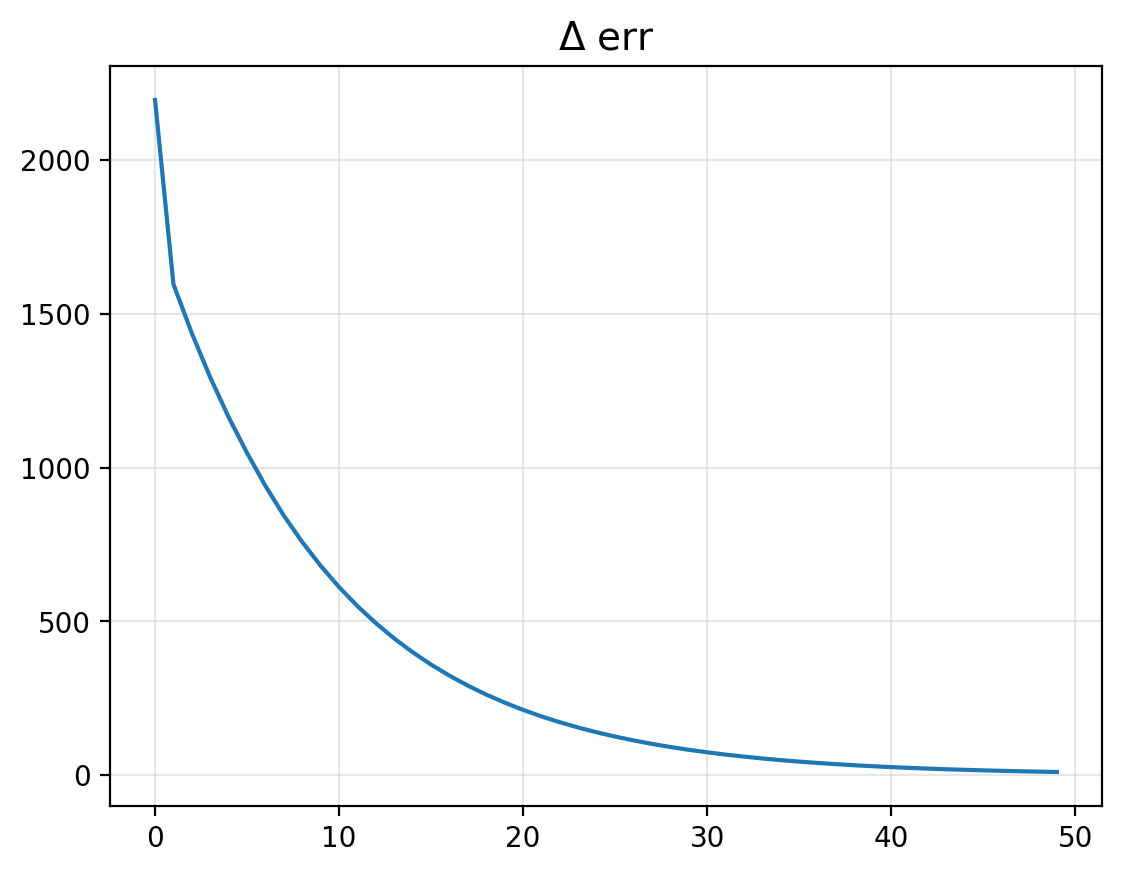

In [15]:
plt.plot(errs_hist)
plt.grid(alpha=0.3)
plt.title("$\Delta$ err", fontsize=14)

Text(0.5, 1.0, 'Cash = 10')

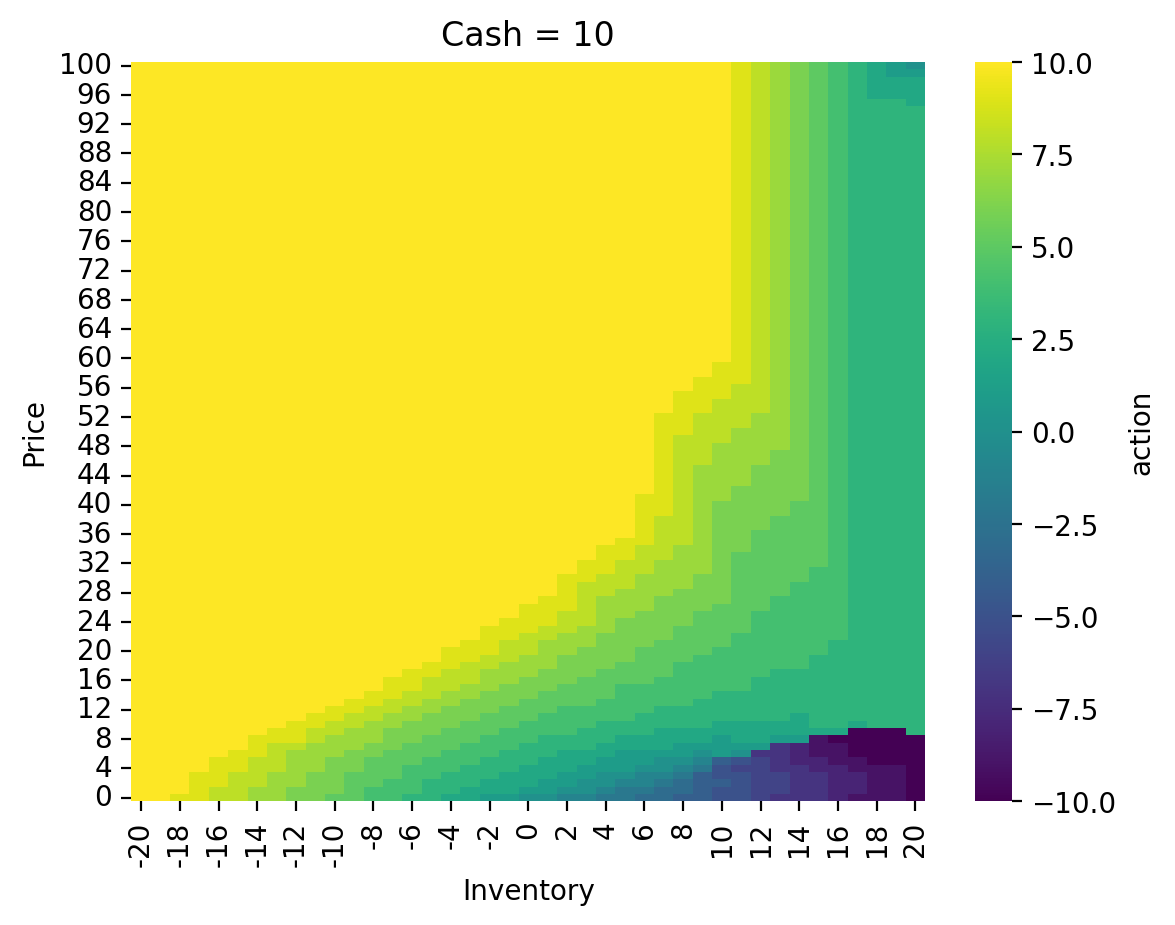

In [16]:
fig, ax = plt.subplots()
cash = 10
cash_ix = cash + MAX_CASH
sns.heatmap(
    pd.DataFrame(action_function[:, :, cash_ix], index=values_price, columns=values_inventory),
    ax=ax,
    cmap="viridis",
    cbar_kws={"label": "action"}
)
ax.set_xlabel("Inventory")
ax.set_ylabel("Price")
ax.invert_yaxis()
plt.title(f"Cash = {cash}")